# Overfitting

... Normally? A bad thing! But for our case it's good...

We use a new method to mix an overfitted model (our own) with a pretrained model (GPT-Neo-125M) and have them share eachothers traits. This way it's possible to finetune a model without having to retrain it. It's so fast it can be done in a second on CPU.

In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches, get_model, set_pretrained_model_dropout, get_dataset, ModelSeeder
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import time
import onnx
import logging
from onnx_model_manager import OnnxModelManager
from onnxruntime.quantization import quantize_dynamic, QuantType
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

In [2]:
# seed = random.randint(0, 2 ** 32 - 1)
seed = 970988852
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 970988852


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    'lr': 0.001,
    "warmup_factor": 5,
    'scheduler': 'cosine_schedule_with_warmup',
    "lr_end": 2e-6,
    "power": 0.6,
    "freeze_from_steps": -1,
    'to_freeze_count': 0,
    "seed": seed,
    "num_epoch": 50
}

In [5]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
    print("Pretrained model loaded")
else:
    model, tokenizer = get_model("EleutherAI/gpt-neo-125M")
    print("Loaded empty model")
model = model.to(device)
# set_pretrained_model_dropout(model.transformer.h, 0.05)

Loaded empty model


# Test before training on a pretrained model!

In [6]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer, device=device)
def test_regular_sampler():
    print(model_manager.say_raw("In my dreams, I'm a dragon", 50, 0.7))
test_regular_sampler()

In my dreams, I'm a dragonflyer, and I was a dragonflyer for a long time.

The first dragonflyer was an all-female, all-female dragonflyer. The dragonflyers were very fond of dragons. They had to be strong and tough, but their power was great, and their ability to kill them was great.

But when the first dragonflyer, called the Red Dragon, was found in the middle of the night, it was all too big for me. I wasn't able to take off my boots because the dragonflyers didn't have a boots-


# Reviewing our dataset!

In [7]:
dataset = get_dataset(tokenizer, path_train = os.path.join(Config.work_dir, "data_train.txt"))
with open("data_train_sample.txt", 'w') as f:
    for i, item in enumerate(dataset['train']):
        f.write(tokenizer.decode(item['input_ids']) + "\n")
        
print("RP review!")
to_see_rp = [
    'c "Fight ',
    'c "What do you think of Lorem?'
]
for item in dataset['train']:
    decoded = tokenizer.decode(item['input_ids'])
    for rp in list(to_see_rp):
        if rp in decoded: 
            print(decoded)
            print("-" * 10)
            to_see_rp.remove(rp)
            continue
    if len(to_see_rp) == 0:
        break
# Clean up
del to_see_rp

  0%|          | 0/2 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors


RP review!


Token indices sequence length is longer than the specified maximum sequence length for this model (2120 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2196 > 2048). Running this sequence through the model will result in indexing errors


 all for today. I'll contact you if we need anything."<p><msg>c "What do you think of Lorem?"<d><scn>office<msg>Sb "I think he is funny."<|endoftext|><d><scn>black<msg>Br "Waiter, next round."<d><scn>black<msg>Wr "Coming."<d><scn>black<msg>Wr "There you go."<d><scn>black<msg>Br "Thanks."<d><scn>black<msg>Wr "How are you holding up?"
----------
>c "Fight Katsuharu"<d><scn>np3<msg>m "Katsuharu dodges my attack and comes rushing towards me"<|endoftext|><d><scn>black<msg>Ry "Oh, I just remembered: I was able to save my game after all. Your interference was only a minor setback."<p><msg>c "Good job, Remy. You're AWESOME."<d><scn>black<msg>Ry "It turned out it wasn't a big deal after all."<d><scn>black<msg>Ry "Oh,
----------


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [8]:
train_results = {}
model.train()
train_model(model, tokenizer, dataset, config, train_results)

[0] set freeze_part_layers: True (freezing 0 out of 160 layers.)


Step,Training Loss
27,2.784800
54,1.907100
81,1.566500
108,1.480000
135,1.151000
162,1.138700
189,0.867000
216,0.941700
243,0.745000
270,0.786400


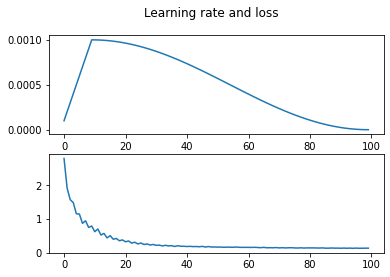

In [9]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

In [10]:
model.eval()
model.save_pretrained(saved_model_path)

In [11]:
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight Maverick",
    "Bite Adine",
    "Attack Adine"
]

for rp in test_rps:
    print(f'{rp} -> {model_manager.say("", rp)}')
    print(f'[sampled] {rp} -> {model_manager.say("", rp, top_k = 50, top_p = 0.7)}')
    print("-" * 10)
    
print("Lowercase test")

for rp in test_rps:
    rp = rp[0].lower() + rp[1:]
    print(f'{rp} -> {model_manager.say("", rp)}')
    rp = rp.lower()
    print(f'{rp} -> {model_manager.say("", rp)}')
    print("-" * 10)

Visit Lorem -> loremapt<msg>Lo "Hey [player_name]!"<|endoftext|>
[sampled] Visit Lorem -> loremapt<msg>Lo "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
----------
Meet with Lorem -> loremapt<msg>Lo "Hey [player_name]!"<|endoftext|>
[sampled] Meet with Lorem -> loremapt<msg>Lo "Oh, [player_name], I wasn't expecting visitors."<|endoftext|>
----------
Visit Adine -> adineapt<msg>Ad "Oh, [player_name], I wasn't expecting visitors."<|endoftext|>
[sampled] Visit Adine -> adineapt<msg>Ad "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
----------
Fight Maverick -> black<msg>m "I didn't hesitate and kicked Maverick right in the stomach"<|endoftext|>
[sampled] Fight Maverick -> black<msg>m "I didn't hesitate and kicked Maverick right in the stomach"<|endoftext|>
----------
Bite Adine -> np2x<msg>Ad "Wtf you think you doing?"<|endoftext|>
[sampled] Bite Adine -> np2x<msg>Ad "Wtf you think you doing?"<|endoftext|>
----------
Attack Adine -> bea

In [12]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hello, [player_name]."', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

def prompt_test(model_manager, do_sample_test = True):
    for (past, prompt) in prompts:
        print(f"Prompt: {prompt}")
        reply = model_manager.say(past, prompt)
        print(f"Reply: {reply}")
        if do_sample_test:
            reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
            print(f"Reply [sampled]: {reply}")
        print("-" * 10)
        
prompt_test(model_manager)

Prompt: How are you?
Reply: park2<msg>Ry "I'm not sure, exactly. It's probably some kind of vegetable blend."<p><msg>c "I see. What kind of meat is commonly eaten around here, anyway?"<d><scn>black<msg>Ry "Aurochs meat. Are you familiar with that animal?"<p><msg>c "I may have heard
Reply [sampled]: park2<msg>Ry "I'm not sure, exactly. It's probably some kind of vegetable blend."<p><msg>c "I see. What kind of meat is commonly eaten around here, anyway?"<d><scn>black<msg>Ry "Aurochs meat. Are you familiar with that animal?"<p><msg>c "I may have heard
----------
Prompt: What do you think of Lorem?
Reply: park2<msg>Ry "I think he's funny."<|endoftext|>
Reply [sampled]: park2<msg>Ry "I think he's cute."<|endoftext|>
----------
Prompt: Oh my god, Adine. What is this?
Reply: black<msg>Ad "It's the practice of doing flying maneuvers like rolls, spins or loops."<p><msg>c "Just flying?"<d><scn>black<msg>Ad "Well, not {i}just{/i} flying."<d><scn>black<msg>Ad "I do Aerobatics, or stunt flying. I'v